In [16]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import make_regression
import numpy as np
import time
import pandas as pd
#matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import math
import pickle
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm1
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn import svm, datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
#%matplotlib widget
import sklearn
from sklearn.datasets import make_regression
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#Funcions necessaries
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

def mse(v1, v2):
    return ((v1 - v2)**2).mean()

def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

Carreguem el dataset sobre el que es treballarà.
Es necessari traduir a binari la variable stable i unstable de la clase stabf per poder treballar amb ella.

Aquest dataset conte les dades necessaries per poder dir si el sistema sobre el "Electrical Grid" es estable o no.

In [3]:

def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',',decimal='.')
    return dataset

dataset = load_dataset('smart_grid_stability_augmented.csv')
label_encoder = sklearn.preprocessing.LabelEncoder()
dataset['stabf']= label_encoder.fit_transform(dataset['stabf'])
dataset

tau1  tau2  tau3  tau4    p1     p2     p3     p4    g1    g2    g3  \
0     2.959 3.080 8.381 9.781 3.763 -0.783 -1.257 -1.723 0.650 0.860 0.887   
1     9.304 4.903 3.048 1.369 5.068 -1.940 -1.873 -1.255 0.413 0.862 0.562   
2     8.972 8.848 3.046 1.215 3.405 -1.207 -1.277 -0.920 0.163 0.767 0.839   
3     0.716 7.670 4.487 2.341 3.964 -1.027 -1.939 -0.997 0.446 0.977 0.929   
4     3.134 7.609 4.944 9.858 3.526 -1.126 -1.846 -0.554 0.797 0.455 0.657   
...     ...   ...   ...   ...   ...    ...    ...    ...   ...   ...   ...   
59995 2.930 2.377 9.488 6.188 3.343 -1.449 -0.658 -1.236 0.602 0.814 0.780   
59996 3.392 2.955 1.275 6.895 4.350 -0.952 -1.664 -1.733 0.502 0.286 0.567   
59997 2.364 8.776 2.842 1.009 4.300 -0.944 -1.381 -1.975 0.488 0.149 0.987   
59998 9.632 2.757 3.994 7.821 2.515 -0.650 -0.966 -0.899 0.365 0.889 0.588   
59999 6.531 4.350 6.782 8.673 3.493 -1.532 -1.390 -0.570 0.073 0.379 0.505   

         g4   stab  stabf  
0     0.958  0.055      1  
1     0.782 -0.006      0  
2     0.110  0.003      1  
3     0.363  0.029      1  
4     0.821  0.050      1  
...     ...    ...    ...  
59995 0.608  0.024      1  
59996 0.366 -0.026      0  
59997 0.146 -0.032      0  
59998 0.818  0.038      1  
59999 0.943  0.045      1  

[60000 rows x 14 columns]

Creem la matriu de correlacions per poder observar posibles bons atributs a treballar.

Aprofitem per enfrentar en una grafica totes les dades entre todes (1vs1) per observar posibles outlayers o posibles concurrencies en les dades.

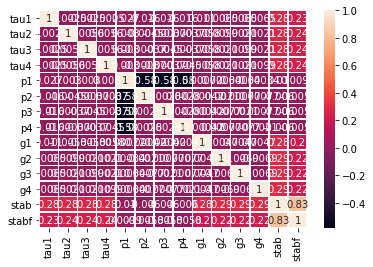

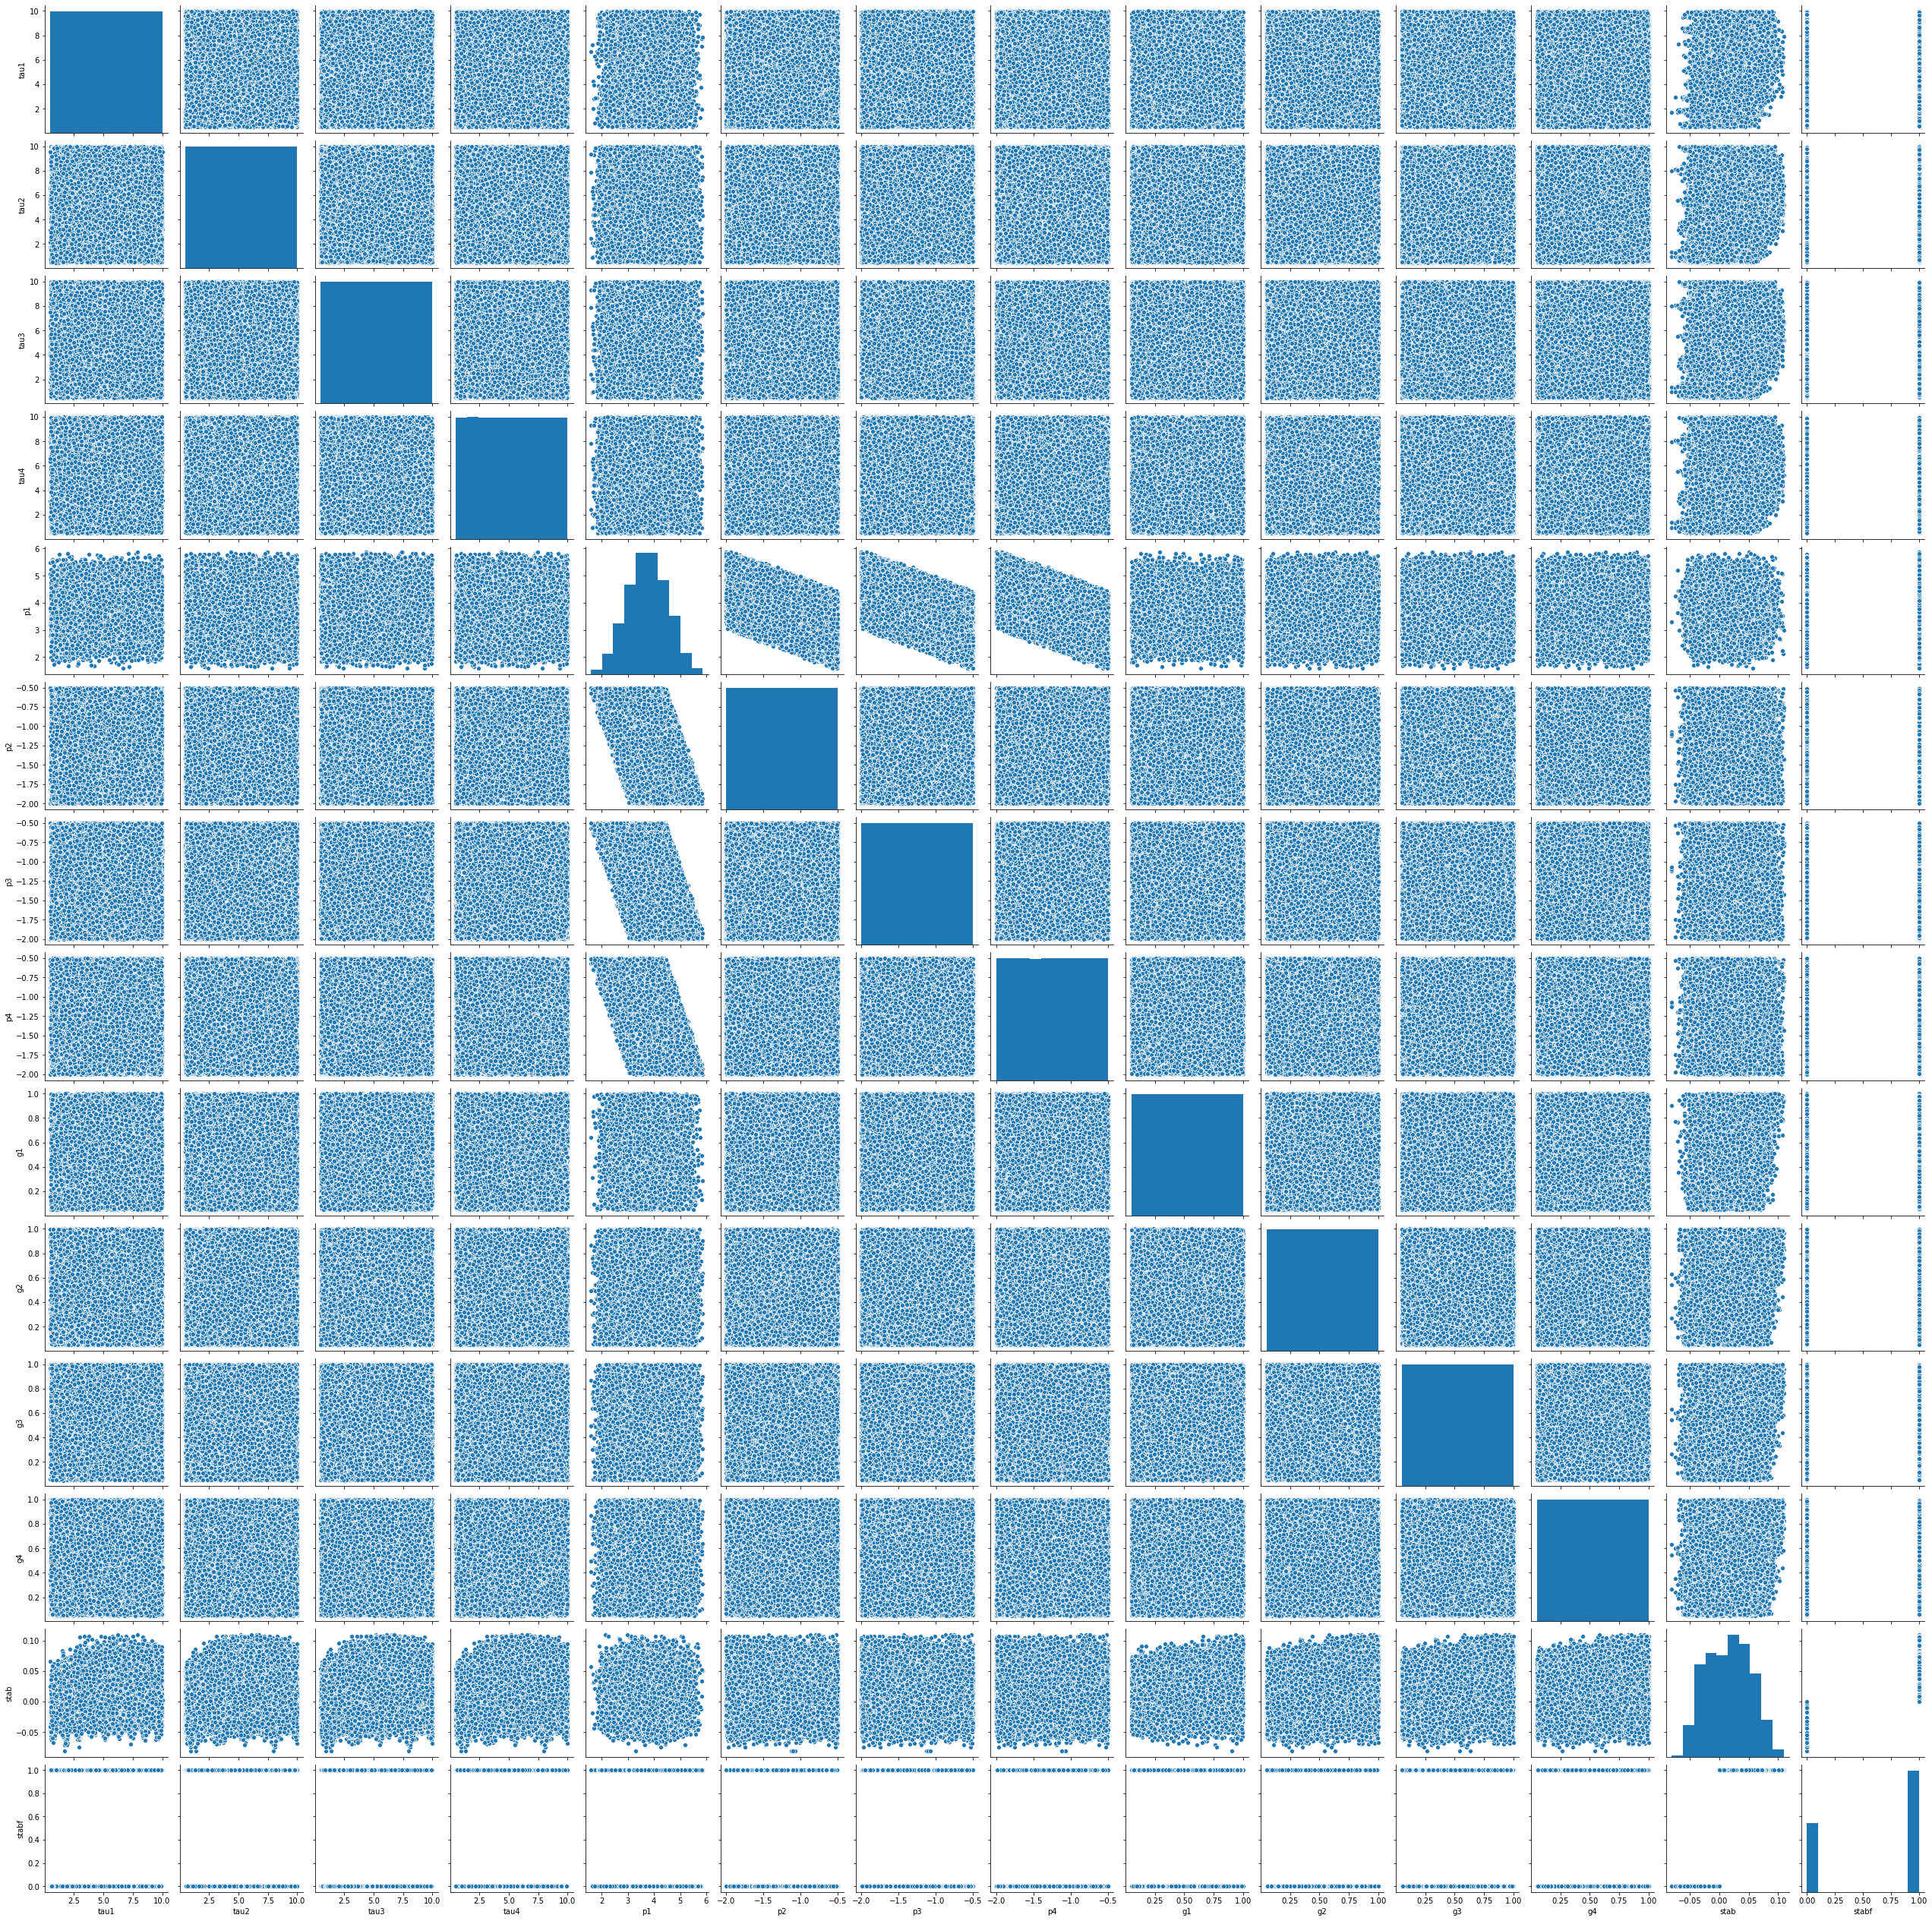

In [4]:
plt.figure()
ax = sns.heatmap(dataset.corr(), annot=True, linewidths=.5)
relacio = sns.pairplot(dataset)


Es pot observar una alta correlació amb les tau i les g. A més veiem que les dades estan identicament distribuides en l'espai en totes les variables, es a dir que no caldrà normalitzar per la bona continuitat d'aquestes dades (sembla que han estat previament ajustades).

Separem les variables dependents de la classificació, com tenim dues formes de diferenciar la stability, una en binari y la altre en brut sense aplicar el "threshold" de decisiò, separem les dues per poder provar quina serà millor per la predicció. 

In [5]:
data = dataset.values
y = data[:,-2]
y_bin = data[:,-1].astype(int)
x = data[:, :12]
type(y_bin[0])

numpy.int32

Eliminem les features que no siguin representatives per predir stabf (per la variable binaria)

In [6]:
x_train, y_train, x_val, y_val = split_data(x, y_bin)
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', solver='liblinear'))
sel_.fit(x_train, np.ravel(y_train, order='C'))
sel_.get_support()
x_train = pd.DataFrame(x_train)
selected_feat = x_train.columns[(sel_.get_support())]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(selected_feat)
x_train_selected = sel_.transform(x_train)
x_test_selected = sel_.transform(x_val)
x_train_selected.shape, x_train_selected.shape
x_selected = np.concatenate((x_train_selected, x_test_selected))
y_selected = np.concatenate((y_train, y_val)) 

total features: 12
selected features: 4
Int64Index([8, 9, 10, 11], dtype='int64')


Apliquem metodes de classificaciò

In [7]:

particions = [0.5]
def apply_models(particions,X,y,ret=False):
    for part in particions:
        x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

        #Creem el regresor logístic
        logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

        # l'entrenem
        logireg.fit(x_t, y_t)
        problr = logireg.predict_proba(x_v)
        print ("Correct classification Logistic        ", part, "% of the data: ", logireg.score(x_v, y_v))

        #Creem el svm
        svc = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True)

        # l'entrenem 
        svc.fit(x_t, y_t)
        probsvc = svc.predict_proba(x_v)
        print ("Correct classification SVM             ", part, "% of the data: ", svc.score(x_v, y_v))

        #Creem el svm lineal
        svcl = svm.SVC(C=10.0, kernel='linear', gamma=0.9, probability=True)

        # l'entrenem 
        svcl.fit(x_t, y_t)
        probsvcl = svcl.predict_proba(x_v)
        print ("Correct classification SVML            ", part, "% of the data: ", svcl.score(x_v, y_v))

        #Creem el svm poly deg=3
        svcp = svm.SVC(C=10.0, kernel='poly', gamma=0.9, probability=True)

        # l'entrenem 
        svcp.fit(x_t, y_t)
        probsvcp = svcp.predict_proba(x_v)
        print ("Correct classification SVMP deg3       ", part, "% of the data: ", svcp.score(x_v, y_v))

        #Creem el svm poly deg=2
        svcp2 = svm.SVC(C=10.0, kernel='poly', degree=2, gamma=0.9, probability=True)

        # l'entrenem 
        svcp2.fit(x_t, y_t)
        probsvcp2 = svcp2.predict_proba(x_v)
        print ("Correct classification SVMP deg2       ", part, "% of the data: ", svcp2.score(x_v, y_v))


        #Creem el svm sigmoid
        svcs= svm.SVC(C=10.0, kernel='sigmoid', gamma=0.9, probability=True)

        # l'entrenem 
        svcs.fit(x_t, y_t)
        probsvcs = svcs.predict_proba(x_v)
        print ("Correct classification SVMS            ", part, "% of the data: ", svcs.score(x_v, y_v))

        #####

        #random forests gini

        clf = RandomForestClassifier(max_depth=2, random_state=0)
        clf.fit(x_t, y_t)
        probclf = clf.predict_proba(x_v)
        print ("Correct classification RFC             ", part, "% of the data: ", clf.score(x_v, y_v))

        #random forests entropy with n_e=1000 and md=5

        clfe = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0,criterion="entropy")
        clfe.fit(x_t, y_t)
        probclfe = clfe.predict_proba(x_v)
        print ("Correct classification RFC etpy        ", part, "% of the data: ", clfe.score(x_v, y_v))

        #####

        #KNN ball_tree

        KNNbt = KNeighborsClassifier(n_neighbors=3,algorithm="ball_tree")
        KNNbt.fit(x_t, y_t)
        probKNNbt = KNNbt.predict_proba(x_v)
        print ("Correct classification KNN BT          ", part, "% of the data: ", KNNbt.score(x_v, y_v))

        #KNN kd_tree

        KNNkd = KNeighborsClassifier(n_neighbors=3,algorithm="kd_tree")
        KNNkd.fit(x_t, y_t)
        probKNNkd = KNNkd.predict_proba(x_v)
        print ("Correct classification KNN KD          ", part, "% of the data: ", KNNkd.score(x_v, y_v))

        #KNN brute

        KNNbrt = KNeighborsClassifier(n_neighbors=3,algorithm="brute")
        KNNbrt.fit(x_t, y_t)
        probKNNbrt = KNNbrt.predict_proba(x_v)
        print ("Correct classification KNN BRT         ", part, "% of the data: ", KNNbrt.score(x_v, y_v))

        #####

        #KNN ball_tree weights = distance

        KNNbtwd = KNeighborsClassifier(n_neighbors=3,algorithm="ball_tree",weights="distance")
        KNNbtwd.fit(x_t, y_t)
        probKNNbtwd = KNNbtwd.predict_proba(x_v)
        print ("Correct classification KNN BT wd=d     ", part, "% of the data: ", KNNbtwd.score(x_v, y_v))

        #KNN kd_tree weights = distance

        KNNkdwd = KNeighborsClassifier(n_neighbors=3,algorithm="kd_tree",weights="distance")
        KNNkdwd.fit(x_t, y_t)
        probKNNkdwd = KNNkdwd.predict_proba(x_v)
        print ("Correct classification KNN KD wd=d     ", part, "% of the data: ", KNNkdwd.score(x_v, y_v))

        #KNN brute weights = distance

        KNNbrtwd = KNeighborsClassifier(n_neighbors=3,algorithm="brute",weights="distance")
        KNNbrtwd.fit(x_t, y_t)
        probKNNbrtwd = KNNbrtwd.predict_proba(x_v)
        print ("Correct classification KNN BRT wd=d    ", part, "% of the data: ", KNNbrtwd.score(x_v, y_v))    
        
        print("\n")
    if ret:
        return [problr,probsvc,probsvcl,probsvcp,probsvcp2,probsvcs,probclf,probclfe,probKNNbt,probKNNkd,probKNNbrt,probKNNbtwd,probKNNkdwd,probKNNbrtwd],x_t, x_v, y_t, y_v
probs_list,x_t, x_v, y_t, y_v=apply_models(particions,x_selected,y_selected,ret=True)

Correct classification Logistic         0.5 % of the data:  0.7178
Correct classification SVM              0.5 % of the data:  0.7234
Correct classification SVML             0.5 % of the data:  0.7189333333333333
Correct classification SVMP deg3        0.5 % of the data:  0.7114
Correct classification SVMP deg2        0.5 % of the data:  0.7192
Correct classification SVMS             0.5 % of the data:  0.44083333333333335
Correct classification RFC              0.5 % of the data:  0.6896
Correct classification RFC etpy         0.5 % of the data:  0.7219
Correct classification KNN BT           0.5 % of the data:  0.6782333333333334
Correct classification KNN KD           0.5 % of the data:  0.6782333333333334
Correct classification KNN BRT          0.5 % of the data:  0.6782333333333334
Correct classification KNN BT wd=d      0.5 % of the data:  0.6841666666666667
Correct classification KNN KD wd=d      0.5 % of the data:  0.6841666666666667
Correct classification KNN BRT wd=d     0.5 

Provem PCA en dues dimensions

In [8]:
dataset_x = dataset.drop(columns='stabf')
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(dataset_x)
pca = PCA(n_components = 2)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
df = pd.DataFrame(reduced, columns = ['pc1','pc2'])
df['stabf'] = dataset['stabf']
df.head()

pc1    pc2  stabf
0  0.220  0.576      1
1  0.579 -0.220      0
2 -0.141 -0.012      1
3  0.073  0.028      1
4  0.060  0.453      1

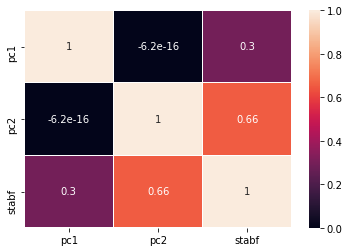

In [9]:
correlacio = df.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.25)
plt.show()

Visualització de la separaciò realitzada per el pca.

In [10]:
X = df.drop(['stabf'],axis=1)
y = df.filter(['stabf'])

#particions = [0.5, 0.7, 0.8]
particions = [0.7]
apply_models(particions,X,y)

Correct classification Logistic         0.7 % of the data:  0.8715
Correct classification SVM              0.7 % of the data:  0.8677222222222222
Correct classification SVML             0.7 % of the data:  0.8722222222222222
Correct classification SVMP deg3        0.7 % of the data:  0.8569444444444444
Correct classification SVMP deg2        0.7 % of the data:  0.6372777777777778
Correct classification SVMS             0.7 % of the data:  0.8327222222222223
Correct classification RFC              0.7 % of the data:  0.8628333333333333
Correct classification RFC etpy         0.7 % of the data:  0.8771666666666667
Correct classification KNN BT           0.7 % of the data:  0.9917777777777778
Correct classification KNN KD           0.7 % of the data:  0.9917777777777778
Correct classification KNN BRT          0.7 % of the data:  0.9917777777777778
Correct classification KNN BT wd=d      0.7 % of the data:  0.999
Correct classification KNN KD wd=d      0.7 % of the data:  0.999
Correct cla

Provem amb el PCA pero optimitzant la variancia al 95%

In [11]:
dataset_x = dataset.drop(columns='stabf')
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(dataset_x)
pca = PCA(n_components = 0.95, svd_solver='full')
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
df = pd.DataFrame(reduced, columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11'])
df['stabf']=dataset['stabf']
df.head()

pc1    pc2    pc3    pc4    pc5    pc6    pc7    pc8    pc9   pc10  \
0  0.220  0.576  0.210  0.149  0.388  0.227  0.408  0.231  0.187  0.270   
1  0.579 -0.220 -0.383 -0.203 -0.222 -0.363 -0.135 -0.097  0.002 -0.406   
2 -0.141 -0.012 -0.065  0.089 -0.744  0.040 -0.070 -0.238 -0.343 -0.568   
3  0.073  0.028  0.197  0.183 -0.623 -0.234  0.275 -0.145 -0.315  0.284   
4  0.060  0.453  0.179  0.078  0.215 -0.522 -0.027  0.217 -0.457  0.375   

    pc11  stabf  
0  0.432      1  
1  0.377      0  
2  0.109      1  
3  0.552      1  
4 -0.018      1

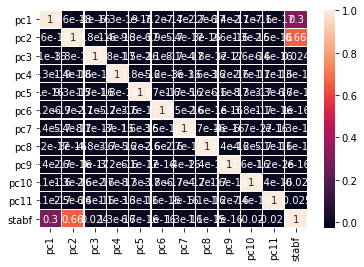

In [12]:
correlacio = df.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.25)
plt.show()

In [13]:
X = df.drop(['stabf'],axis=1)
y = df.filter(['stabf'])

#particions = [0.5, 0.7, 0.8]
particions = [0.7]
apply_models(particions,X,y)

Correct classification Logistic         0.7 % of the data:  0.8735
Correct classification SVM              0.7 % of the data:  0.9864444444444445
Correct classification SVML             0.7 % of the data:  0.8731111111111111
Correct classification SVMP deg3        0.7 % of the data:  0.9489444444444445
Correct classification SVMP deg2        0.7 % of the data:  0.7154444444444444
Correct classification SVMS             0.7 % of the data:  0.8079444444444445
Correct classification RFC              0.7 % of the data:  0.8254444444444444
Correct classification RFC etpy         0.7 % of the data:  0.8838333333333334
Correct classification KNN BT           0.7 % of the data:  0.9166111111111112
Correct classification KNN KD           0.7 % of the data:  0.9166111111111112
Correct classification KNN BRT          0.7 % of the data:  0.9166111111111112
Correct classification KNN BT wd=d      0.7 % of the data:  0.9184444444444444
Correct classification KNN KD wd=d      0.7 % of the data:  0.91


def func_LeaveOneOut(X,y):

    loo = LeaveOneOut()
    loo.get_n_splits(X)
    accuracy=0
    for train_index, test_index in loo.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)
        logireg.fit(X_train, y_train)
        problr = logireg.predict_proba(X_test)
        accuracy+=logireg.score(X_test, y_test)
        #print(X_train, X_test, y_train, y_test)
    print("Accuracy LeaveOneOut:",accuracy/len(y))
    
X=x_selected
y=y_selected
func_LeaveOneOut(X,y)

Observem que el millor es el model de amb un PCA de dues dimensions sobre la classificaciò feta per el KNN amb 3 veins, amb l'algoritme kd_tree i que els pesos vinguin donats per la distancia.

Comprovem amb cross-validation si les dades són certes

In [14]:
dataset_x = dataset.drop(columns='stabf')
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(dataset_x)
pca = PCA(n_components = 2)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
df = pd.DataFrame(reduced, columns = ['pc1','pc2'])
df['stabf']=dataset['stabf']
df.head()

X=df.drop(['stabf'],axis=1)
y=df.filter(['stabf'])

x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.7)
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3,algorithm="kd_tree",weights="distance"))

scores = cross_val_score(pipeline, X=x_t, y=y_t, cv=1000, n_jobs=-1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        

Fem una recerca d'hiperparametres per trobar els millors atributs del model classificador.

In [37]:
def Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,search_type,name_save,algorithms=["auto"],weight=["uniform"]):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.7)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, algorithm=algorithms,weights=weight)
    knn_2 = KNeighborsClassifier()
    start_time = time.time()
    if (search_type=="Grid search"):
        clf = GridSearchCV(knn_2, hyperparameters, cv=cv,n_jobs=-1)
    else:
        clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, n_jobs=-1, cv=cv)
    best_model = clf.fit(x_t,y_t)
    pickle.dump(best_model, open(name_save, "wb"))
    print(search_type)
    print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
    print('Best p:', best_model.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
    print('Precision at best_score:',best_model.score(x_v,y_v))
    print("--- %s seconds ---" % (time.time() - start_time))

In [45]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
leaf_size = list(range(1,20))
n_neighbors = list(range(1,2))
p=[1,2]
n_splits=10
n_repeats=3
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Grid search","KnC_grid.sav")
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Random search","KnC_RS.sav")


Grid search
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
Precision at best_score: 0.9986666666666667
--- 19.70036816596985 seconds ---
Random search
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
Precision at best_score: 0.9986666666666667
--- 18.92009735107422 seconds ---


In [38]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
n_splits=10
n_repeats=3
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Grid search","KnC_grid.sav")
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Random search","KnC_RS.sav")


Grid search
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
Precision at best_score: 0.9993333333333333
--- 1741.708728313446 seconds ---
Random search
Best leaf_size: 18
Best p: 2
Best n_neighbors: 1
Precision at best_score: 0.999
--- 317.8199369907379 seconds ---


In [42]:
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.7)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
leaf_size = list(range(1,25))
n_neighbors = list(range(1,15))
p=[1,2]
n_splits=10
n_repeats=3
algorithms=["kd_tree","brute","ball_tree"]
weight=["distance","uniform"]
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Grid search","KnC_grid.sav")
Hyperparam_search_KNC(X,y,n_splits,n_repeats,leaf_size,n_neighbors,p,"Random search","KnC_RS.sav")


KeyboardInterrupt: 

Provem també amb el random Forest amb totes les dades inicials.

In [ ]:
def Hyperparam_search_RF(X,y,n_splits,n_repeats,n_estimators,cv,max_depth,min_samples_split,min_samples_leaf,bootstrap,search_type,name_save):
    x_t,x_v,y_t,y_v = train_test_split(x_selected, y_selected, test_size=0.7)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,bootstrap=bootstrap)
    R_f=RandomForestClassifier()
    start_time = time.time()
    if (search_type=="Grid search"):
        clf = GridSearchCV(R_f, hyperparameters,n_jobs=-1, cv=cv)
    else:
        clf = RandomizedSearchCV(R_f, hyperparameters, n_iter=80, n_jobs=-1, cv=cv)
    best_model = clf.fit(x_t,y_t)
    pickle.dump(best_model, open(name_save, "wb"))
    print(search_type)
    print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
    print('Best p:', best_model.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
    print('Precision at best_score:',best_model.score(x_v,y_v))
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#x_t,x_v,y_t,y_v = train_test_split(x_selected, y_selected, test_size=0.7)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 5)]
n_splits=10
n_repeats=3
max_depth =[int(x) for x in np.linspace(0, 10, 1)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(0, 5, 1)]
min_samples_leaf = [int(x) for x in np.linspace(0, 5, 1)]
bootstrap = [True, False]
Hyperparam_search_RF(x_selected,y_selected,n_splits,n_repeats,n_estimators,cv,max_depth,min_samples_split,min_samples_leaf,bootstrap,"Grid search","R_f_little_grid.sav")
Hyperparam_search_RF(x_selected,y_selected,n_splits,n_repeats,n_estimators,cv,max_depth,min_samples_split,min_samples_leaf,bootstrap,"Random search","R_f_little_RD.sav")

In [ ]:
x_t,x_v,y_t,y_v = train_test_split(x_selected, y_selected, test_size=0.7)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 5)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(0, 10, 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(0, 5, 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(0, 5, 1)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
R_f=RandomForestClassifier()
start_time = time.time()
clf =GridSearchCV(R_f, random_grid,n_jobs=-1, cv=cv)
best_model = clf.fit(x_t,y_t)
pickle.dump(best_model, open("R_f_grid.sav", "wb"))
print('Grid search')
print('Best number of estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Bootstrap:', best_model.best_estimator_.get_params()['bootstrap'])
print('R^2 at best_score:',best_model.score(x_v,y_v))
print("--- %s seconds ---" % (time.time() - start_time))

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1100, num = 1100)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(1, 5, 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = list(range(2,11))
# Minimum number of samples required at each leaf node
min_samples_leaf = list(range(1,5))
# Method of selecting samples for training each tree
bootstrap = [True, False]
start_time = time.time()
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
clf =  RandomizedSearchCV(R_f, random_grid, n_iter=80, n_jobs=-1, cv=cv)
#Fit the model
best_model = clf.fit(x_t,y_t)

pickle.dump(best_model, open("R_f_RD.sav", "wb"))

#Print The value of best Hyperparameters
print('Random search')
print('Best number of estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Bootstrap:', best_model.best_estimator_.get_params()['bootstrap'])
print('R^2 at best_score:',best_model.score(x_v,y_v))
print("--- %s seconds ---" % (time.time() - start_time))

In [39]:
modelKnC_grid=pickle.load(open("KnC_grid.sav", "rb")) #para abrirlos
modelKnC_grid.score(x_v,y_v)

0.9993333333333333

In [40]:
modelKnC_RS=pickle.load(open("KnC_RS.sav", "rb")) #para abrirlos
modelKnC_RS.score(x_v,y_v)

0.999